# Ball Tracking

In [1]:
%load_ext autoreload
%autoreload 2

## Prepare dataset

First, we'll prepare the dataset. To perform tuning we also need the ground truth tracking data.

In [2]:
import sportslabkit as slk

root = slk.utils.get_git_root()

dataset_path = slk.datasets.get_path('top_view')
path_to_csv = sorted(dataset_path.glob('annotations/*.csv'))[-1]
path_to_mp4 = sorted(dataset_path.glob('videos/*.mp4'))[-1]

bbdf_gt = slk.load_df(path_to_csv) # We will use this as ground truth
cam = slk.Camera(path_to_mp4) # Camera object will be used to load frames

n_frames = 100 # Let's reduce the number of frames to 100 for now

Next, we will use the `get_data` funciton to isolate the ground truth data regarding the ball.

In [3]:
bbdf_gt = bbdf_gt.get_data(teamid='BALL')[:n_frames]
print(bbdf_gt.shape)
bbdf_gt.head()

(100, 5)


TeamID          BALL                              
PlayerID        BALL                              
Attributes bb_height bb_left  bb_top bb_width conf
frame                                             
1               16.0  2244.0  1624.0     16.0  1.0
2               13.0  2237.0  1626.0     15.0  1.0
3               13.0  2230.9  1627.9     15.0  1.0
4               13.0  2224.8  1629.8     15.0  1.0
5               13.0  2218.7  1631.7     15.0  1.0

## Visualize the ground truth data

In [4]:
from IPython.display import Video

bbdf_gt.visualize_frames(path_to_mp4, save_path=root / 'notebooks/02_user_guide/assets/ball_tracking_gt.mp4')
Video(root / 'notebooks/02_user_guide/assets/ball_tracking_gt.mp4')

Writing video: 100it [00:07, 13.72it/s]


## Prepare the detection model 

Although the original paper uses the Faster Region CNN (FrRCNN) detection framework for object detection, we will use fine-tuned YOLOv8 models trained on the soccertrack drone dataset as it is faster and more accurate. The model checkpoints can be downloaded from [here](https://drive.google.com/drive/u/1/folders/1XPQS5xr-NidQM78eAw5AJjZ5gsbSqu3j). Change the path in `model` accordingly.

     bbox_left     bbox_top  bbox_width  bbox_height      conf  class
0   450.195831  1881.303223   13.981934    13.116943  0.441604    1.0
1  2242.264893  1623.762085   18.089355    17.664551  0.405767    1.0


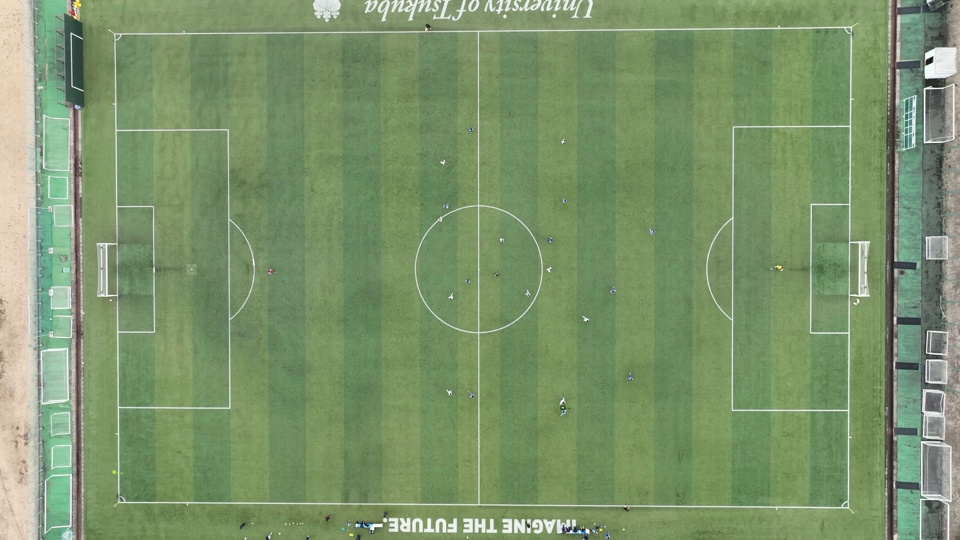

In [5]:
frame = cam[0]

det_model = slk.detection_model.load(
    'yolov8',
    model=root / 'models/yolov8/soccer_top_view-model=yolov8x-imgsz=2048.pt', # path to the checkpoint file
    classes=[1], # class index of ball to be detected
    imgsz=2560,
    device='cuda'
)

det_result = det_model(frame)[0]

print(det_result.to_df())
im = det_result.show(width=5)
im.resize((im.width//4, im.height//4))

## Prepare image model and motion models

In [6]:
image_model = slk.image_model.load('OSNet_ibn_x1_0')
motion_model = slk.motion_model.load('KalmanFilter')

## Tracking with MOT models (DeepSORT)

In [7]:
from sportslabkit.mot import DeepSORTTracker

sot_tracker = DeepSORTTracker(
    detection_model=det_model,
    image_model=image_model,
    motion_model=motion_model,
    t_lost=30
)

bbdf_pred = sot_tracker.track(cam[:n_frames])

Tracking Progress: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


In [8]:
from sportslabkit.metrics import hota_score

score = hota_score(bbdf_pred, bbdf_gt)['HOTA']
print(f"HOTA score: {score:.2f}")

HOTA score: 0.06


In [9]:
from IPython.display import Video

bbdf_pred.visualize_frames(path_to_mp4, save_path=root / 'notebooks/02_user_guide/assets/ball_tracking_deepsort.mp4')
Video(root / 'notebooks/02_user_guide/assets/ball_tracking_deepsort.mp4')

Writing video: 100it [00:10,  9.29it/s]


The Hota score turns out to be very bad for this example. If you look at the video, you'll see that there are multiple ID switches for the ball. This is because assignment is based on IoU and so for small objects that move fast like a ball, the IoU is very low or zero. To fix this, we need to use a different metric for assignment.

Next, we'll use `EuclideanCMM` instead of the default `IoUCMM`.

In [10]:
from sportslabkit.metrics import EuclideanCMM

sot_tracker = DeepSORTTracker(
    detection_model=det_model,
    image_model=image_model,
    motion_model=motion_model,
    motion_metric=EuclideanCMM(),
    t_lost=30
)

bbdf_pred = sot_tracker.track(cam[:n_frames])

Tracking Progress: 100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


In [11]:
score = hota_score(bbdf_pred, bbdf_gt)['HOTA']
print(f"HOTA score: {score:.2f}")

bbdf_pred.visualize_frames(path_to_mp4, save_path=root / 'notebooks/02_user_guide/assets/ball_tracking_deepsort_euclid.mp4')
Video(root / 'notebooks/02_user_guide/assets/ball_tracking_deepsort_euclid.mp4')

HOTA score: 0.49


Writing video: 100it [00:06, 14.44it/s]


Although the results have improved by a lot, there are still some problems.

* Several times the ball is not detected at all.
* Balls outside the field are detected.
* The ball is detected in the wrong place.

etc.

Next, we will prepare code to perform post-processing to improve the HOTA score. The code below consists of three main functions, each aimed at a specific part of the improvement process.

- `center_in_hull_n_times``: This function takes a DataFrame and a convex hull, iterating through each bounding box's center and checking if it lies within the convex hull. It returns the count of times the center is found inside or on the edge of the hull.
- `get_most_valid_player_df`: This function iterates through players' data and calls the previously mentioned function to get the count of times a player's bounding box is inside the hull. It then returns the DataFrame of the player with the maximum count, effectively finding the most valid player according to the given convex hull.
- `draw_convex_hull`: This function takes an image and a convex hull and draws the contours and corners of the hull on the image, allowing for visualizatio

Additionally, missing frames are interpolated using  = `get_most_valid_player_df(bbdf_pred, hull).interpolate()`, which fills gaps in the tracked data.

These functions collectively work towards filtering out incorrect detections by focusing on valid bounding boxes inside a defined area. By aligning the tracked object with the constraints of the field, interpolating missing frames, and specific regions of interest, the system aims to enhance the tracking accuracy by minimizing false positives and negatives. The ultimate goal is to achieve more precise and reliable tracking, thus potentially increasing the HOTA score in the sports tracking scenario.





tid: 0, pid: 129336024528, n_times: 3
tid: 0, pid: 133289767642, n_times: 95
tid: 0, pid: 258584933653, n_times: 1
tid: 0, pid: 270311614045, n_times: 2
tid: 0, pid: 287362966292, n_times: 1
tid: 0, pid: 544354461944, n_times: 0
133289767642


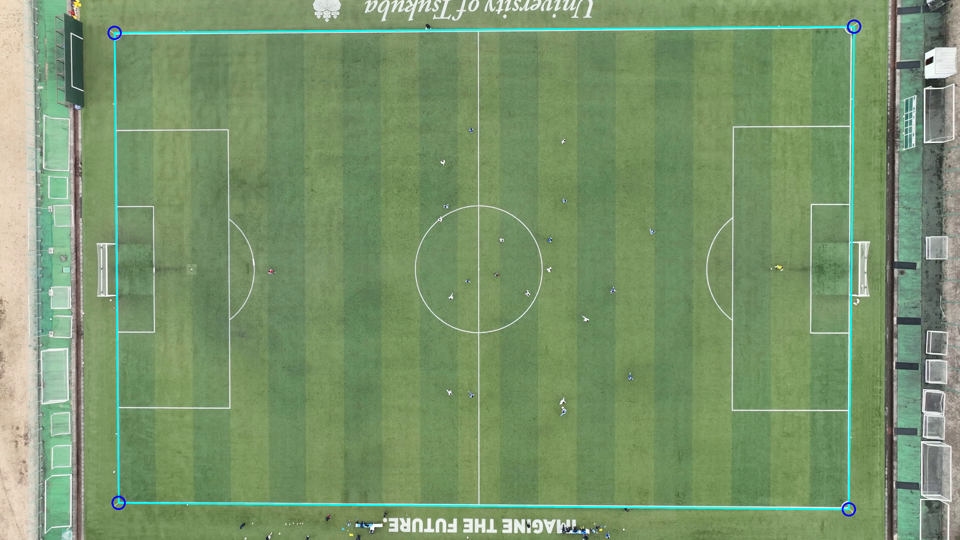

In [12]:
import cv2
import numpy as np

def center_in_hull_n_times(df, hull):
    n_times = 0
    df = df.dropna()
    for index, row in df.iterrows():
        center_x = row['bb_left'] + row['bb_width'] / 2
        center_y = row['bb_top'] + row['bb_height'] / 2
        center = (center_x, center_y)
        
        # Test if the center is inside the hull
        result = cv2.pointPolygonTest(hull, center, measureDist=True)
        # result = 1 means inside, 0 on the hull, -1 outside
        if result >= 0:
            n_times += 1
    return n_times

def get_most_valid_player_df(df, hull):
    most_valid_n_times = 0
    for (tid, pid), player_df in bbdf_pred.iter_players():
        n_times = center_in_hull_n_times(player_df, hull)
        if n_times > most_valid_n_times:
            most_valid_n_times = n_times
            most_valid_pid = pid
        print(f"tid: {tid}, pid: {pid}, n_times: {n_times}")
    print(most_valid_pid)
    return df.get_data(playerid=most_valid_pid)

def draw_convex_hull(image, hull):
    # draw contours
    image = image.copy()
    cv2.drawContours(image, [hull], 0, (0, 255, 255), 5)

    # draw corners
    for point in hull:
        cv2.circle(image, point[0], 25, (0, 0, 255), 5)
    return image


pts = np.array([[458, 131], [474, 2011], [3416, 106], [3395, 2037]])
hull = cv2.convexHull(pts)
valid_bbdf_pred = get_most_valid_player_df(bbdf_pred, hull).interpolate()
im = slk.utils.cv2pil(draw_convex_hull(frame, hull), convert_bgr2rgb=False)
im.resize((im.width//4, im.height//4))

In [13]:
score = hota_score(valid_bbdf_pred, bbdf_gt)['HOTA']
print(f"HOTA score: {score:.2f}")

valid_bbdf_pred.visualize_frames(path_to_mp4, save_path=root / 'notebooks/02_user_guide/assets/ball_tracking_deepsort_valid.mp4')
Video(root / 'notebooks/02_user_guide/assets/ball_tracking_deepsort_valid.mp4')

HOTA score: 0.73


Writing video: 0it [00:00, ?it/s]

Writing video: 100it [00:06, 14.37it/s]
